TODO:
    siflis
    HIV tratamento e controle
    grupos proximos: idade
    taxas de crescimento
    
ideia: baseado em um modelo SIR calcular o valor esperado de numero de contaminados em 2018. 
A diferença entre o valor esperado e o atual seria 

# HIV prevention policy: an econometric evaluation
#### Since 2018,  a medication that prevents hiv indections has been distributed in Brazil.

#### Medication is available to groups historically vunerable to HIV: sex workers, transexual women and homossexual man.

# 3 counterfactuals:
#### Treated and non-treated groups in the same city/region: 
* Outcome variable: new infections after treatment started
* Treated: homossexual group
* Control: heterossexual group

#### The homossexual group in treated and non-treated cities

#### New HIV cases and Hepatites cases in treated group

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.rcParams["figure.figsize"] = [4,3]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
pd.set_option('display.max_columns', 500)
sns.set_style("whitegrid")
plt.style.use('./graph_config.mplstyle')

HET_COLOR = "#00A4CCFF"# "#00A4CCFF"
GAY_COLOR = "#F95700FF" # "#F95700FF"
palette_hetgay = [HET_COLOR,GAY_COLOR]

label_het = "Heterossexual (Control)"
label_gay = "Homossexual man (Treated)"
order_hetgay = [label_het,
                label_gay]

SINGLE_COLOR="#b3c6ff"
BINNED_COLOR="#b3c6ff"

filter_years = [2014,2015, 2016,2017,2018,2019,2020,2021,2022]

#### useful functions

In [2]:
def melt_groups(df, cols, id_vars=["name","code","year","treated"]):
    # Example: melt_groups(cases, ["hiv_m","hiv_f"])
    return (df.melt(id_vars=id_vars,
               value_vars=cols,
               var_name="group")
          .rename(columns={"variable":"code",
                           "value":"cases"}))

def binned_data(df, var, dict_hist):
    labels = []
    values = []
    for label,interval in dict_hist.items():
        start = interval[0]
        end = interval[1]
        query = f"{var} >= {start} & {var} <= {end}"
        labels.append(label)
        value = df[label] = df.query(query).shape[0]
        values.append(value)

    return pd.DataFrame({"labels":labels, "values":values})

#### outcome variable

##### cities

In [713]:
cases = pd.read_csv("data/cases_cleaned.csv")
cases = cases.sort_values(['code','year'])
cases = cases.set_index(['code','year','name'])

cities = pd.read_csv("data/cities.csv")
cities = cities.sort_values(['code','year'])
cities = cities.set_index(['code'])#,'year','name'
cities["hiv_het"] = cities["hiv_m"] - cities["hiv_h"]
cities = cities.query("state_code != 42") # missing data for Santa Catarina

regions = pd.read_csv("data/regions.csv")
regions = regions.sort_values(['region_code','year'])
regions = regions.set_index(['region_code'])#,'year','name'
regions["hiv_het"] = regions["hiv_m"] - regions["hiv_h"]
regions = regions.query("state_code != 42") # missing data for Santa Catarina

#def pct_change_2(series):
#    return series.pct_change(2)
#
#outcomes = (cities
#            #.set_index(['code','year','name'])
#    .groupby(["code"])
#    .agg({"hiv_total": "pct_change",
#          "hep_b_total":"pct_change",
#          "hep_b_m":"pct_change",
#          "hep_b_f":"pct_change",
#          "hiv_h":"pct_change",
#          "hiv_het":"pct_change",
#          "hiv_f":"pct_change"}))
#
#outcomes = outcomes.add_suffix('_pct_change')
#cities = pd.concat([cities, outcomes], axis=1).reset_index().set_index("code")
#
#cities["hiv_het_pct_change_follow_year"] = cities.shift(-1)["hiv_het_pct_change"]
#cities["hiv_h_pct_change_follow_year"] = cities.shift(-1)["hiv_h_pct_change"]


In [720]:
def compute_treatment_intensity(df):
    df = df.set_index("year")
    baseline_het = df.loc[2018]["hiv_het"].mean()
    baseline_h = df.loc[2018]["hiv_h"].mean()
    baseline_f = df.loc[2018]["hiv_f"].mean()

    df.loc[2019:2022,"diff_to_baseline_het"] = df.loc[2019:2022]["hiv_het"] - baseline_het
    df.loc[2019:2022,"pct_chg_to_baseline_het"] = (df.loc[2019:2022]["hiv_het"] - baseline_het)/baseline_het
    df.loc[2019:2022,"diff_to_baseline_f"] = df.loc[2019:2022]["hiv_f"] - baseline_f
    df.loc[2019:2022,"pct_chg_to_baseline_f"] = (df.loc[2019:2022]["hiv_f"] - baseline_f)/baseline_f

    df.loc[2019:2022,"diff_to_baseline_h"]      = df.loc[2019:2022]["hiv_h"] - baseline_h
    df.loc[2019:2022,"pct_chg_to_baseline_h"]   = (df.loc[2019:2022]["hiv_h"] - baseline_h)/baseline_h
    df.loc[2019:2022,"diff_treat_control"] = df.loc[2019:2022]["pct_chg_to_baseline_h"] - df.loc[2019:2022]["pct_chg_to_baseline_het"]
    df.loc[2019:2022,"diff_treat_control_f"] = df.loc[2019:2022]["pct_chg_to_baseline_h"] - df.loc[2019:2022]["pct_chg_to_baseline_f"]

    df["cummulative_prep"] = 0
    df.loc[2018,"cummulative_prep"] = df.loc[2018,"new_users"]/2

    for y in range(2019,2023):
        df.loc[y,"cummulative_prep"] = (df.loc[y-1,"cummulative_prep"] + 
                                          df.loc[y-1,"new_users"] + 
                                          df.loc[y,"new_users"]/2)

    df["treatment_intensity"] = df["cummulative_prep"]/baseline_h
    df = df.replace(np.inf, None)
    df = df.replace(-np.inf, None)
    return df
cities_reg = cities.groupby("code").apply(compute_treatment_intensity).reset_index()
cities_reg = cities_reg.set_index("code")

regions_reg = regions.groupby("region_code").apply(compute_treatment_intensity).reset_index()
regions_reg = regions_reg.set_index("region_code")

##### regions

In [517]:
#regions = pd.read_csv("data/regions.csv")
#
#regions = regions.set_index(['region_code','year','region_name'])
#outcomes_region = (regions
#            #.set_index(['code','year','name'])
#        .groupby("region_code")
#        .agg({
#             "hiv_total":"pct_change",
#             "hiv_h":"pct_change",
#             "hiv_het":"pct_change",
#             "hiv_bi":"pct_change",
#             "hiv_f":"pct_change",
#             "hep_b_total":"pct_change",
#             "hep_b_m":"pct_change",
#             "hep_b_f":"pct_change",
#             "following":"pct_change",
#             "loss_of_follow":"pct_change",
#             "new_users":"pct_change"
#})
#)
##regions = regions.reset_index().set_index("region_code")
#
#outcomes_region = outcomes_region.add_suffix('_pct_change')
#regions = pd.concat([regions, outcomes_region], axis=1).reset_index().set_index("region_code")
#
#regions["hiv_het_pct_change_follow_year"] = regions.shift(-1)["hiv_het_pct_change"]
#regions["hiv_h_pct_change_follow_year"] = regions.shift(-1)["hiv_h_pct_change"]

#### Data description

#### barplot count homossexual x het

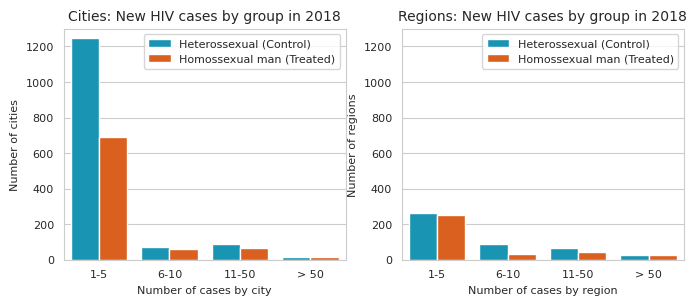

In [646]:
dict_hist = {
    "1-5":  [1,5],
    "6-10": [6,10],
    "11-50":[11,50],
    "> 50": [50,100000]
}

het_count_hist = binned_data(cities.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(cities.query("year == 2018"), "hiv_h", dict_hist)

het_count_hist["group"] = label_het
gay_count_hist["group"] = label_gay


hist_count_cities = pd.concat([het_count_hist, gay_count_hist])

##### CITIES

fig, ax = plt.subplots(figsize=(8,3))
plt.subplot(1, 2, 1)
g = sns.barplot(hist_count_cities,
             x="labels", y="values", hue="group",
                palette=palette_hetgay,
                hue_order=order_hetgay)

plt.title("Cities: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of cities")
plt.xlabel("Number of cases by city")
plt.ylim([0,1300])


##### REGION

plt.subplot(1, 2, 2)
het_count_hist = binned_data(regions.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(regions.query("year == 2018"), "hiv_h", dict_hist)

het_count_hist["group"] = label_het
gay_count_hist["group"] = label_gay

hist_count_region = pd.concat([het_count_hist, gay_count_hist])

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(hist_count_region,
             x="labels", y="values", hue="group",
             palette=palette_hetgay,
             hue_order=order_hetgay)

plt.title("Regions: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of regions")
plt.xlabel(f"Number of cases by region")

plt.savefig("graphs/new_cases_by_city_region.png", 
               bbox_inches='tight')
plt.ylim([0,1300])
plt.show()

#### New users by year

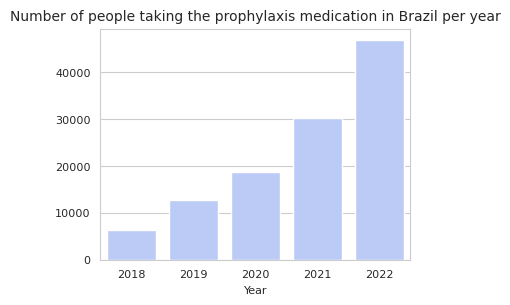

In [652]:
from numpy import count_nonzero
ax = sns.barplot(x="year", y="following",
                 data=cities.query("year in [2018,2019,2020,2021,2022]"),
                 estimator=np.sum, color=SINGLE_COLOR)
plt.title("Number of people taking the prophylaxis medication in Brazil per year")
plt.xlabel("Year")
plt.ylabel("")

plt.savefig("graphs/prep_numbers_brazil.png", 
               bbox_inches='tight', dpi=150)
plt.show()

### New HIV cases by year

(0.0, 8000.0)

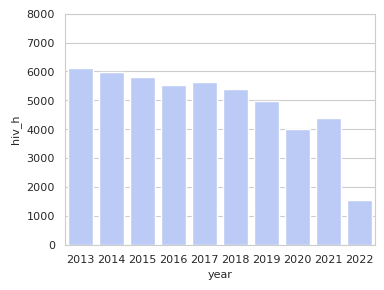

In [535]:
from numpy import count_nonzero
ax = sns.barplot(x="year", y="hiv_h",
                 data=cases.loc[55].reset_index(),
                 color=SINGLE_COLOR)
plt.ylim([0,8000])

(0.0, 8000.0)

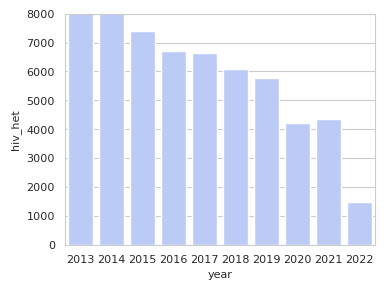

In [534]:
sns.barplot(x="year", y="hiv_het",
                 data=cases.loc[55].reset_index(),
                 color=SINGLE_COLOR)
plt.ylim([0,8000])

### Number of cities by level of treatment by year

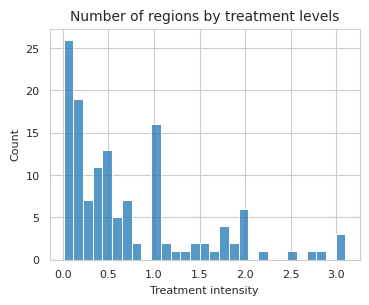

In [8]:
sns.histplot(cities.query("year == 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,3.1,30))
plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

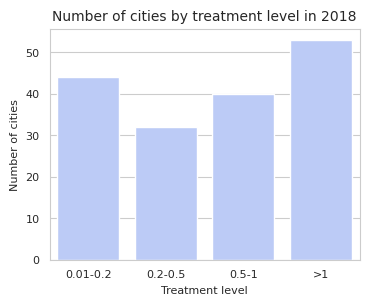

In [9]:
#cases_scatter = cities.query(f"""year == 2018 & pct_following > 0.01 & pct_following < 5 & hiv_h_pct_change < 2 & hiv_h > 5""")
#sns.scatterplot(cases_scatter,
#                x="hiv_h",
#                y="pct_following")

dict_hist = {
    "0.01-0.2": [0.01,0.2],
    "0.2-0.5": [0.2,0.5],
    "0.5-1": [0.5,1],
    ">1": [1,10],
}

cities_by_treat_level = binned_data(cities.query("year == 2018"), "pct_new_users", dict_hist)

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(cities_by_treat_level,
             x="labels", y="values",color=BINNED_COLOR)

plt.title("Number of cities by treatment level in 2018",fontsize=10)
plt.ylabel("Number of cities")
plt.xlabel(f"Treatment level")

plt.savefig("graphs/cities_by_treat_level.png", 
               bbox_inches='tight', )
plt.show()

### Histogram: cities by treatment level

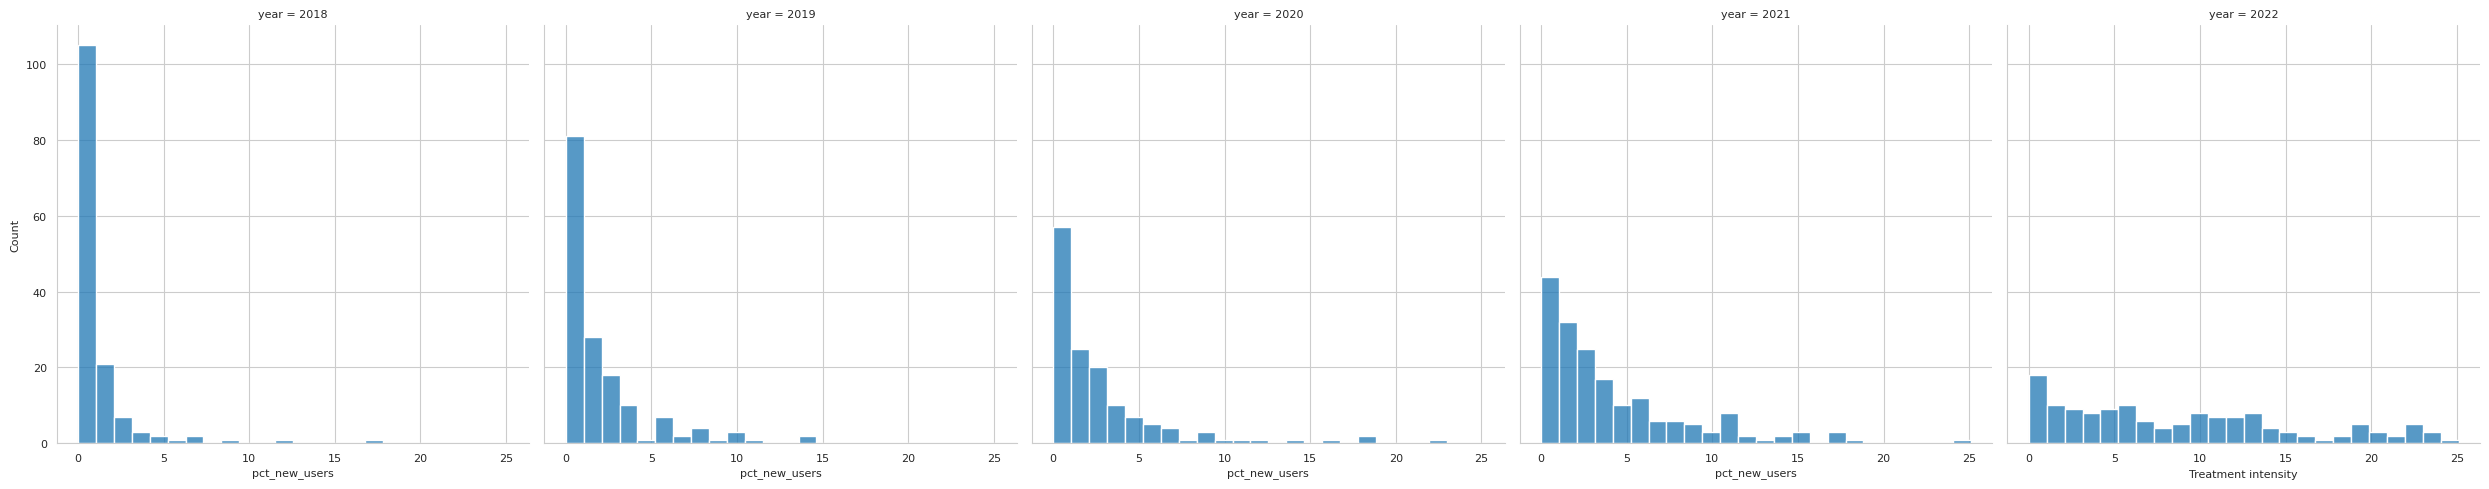

In [552]:
sns.displot(cities.reset_index().query("year >= 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,25.1,25), col="year")
#plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

### Histogram: regions by treatment level

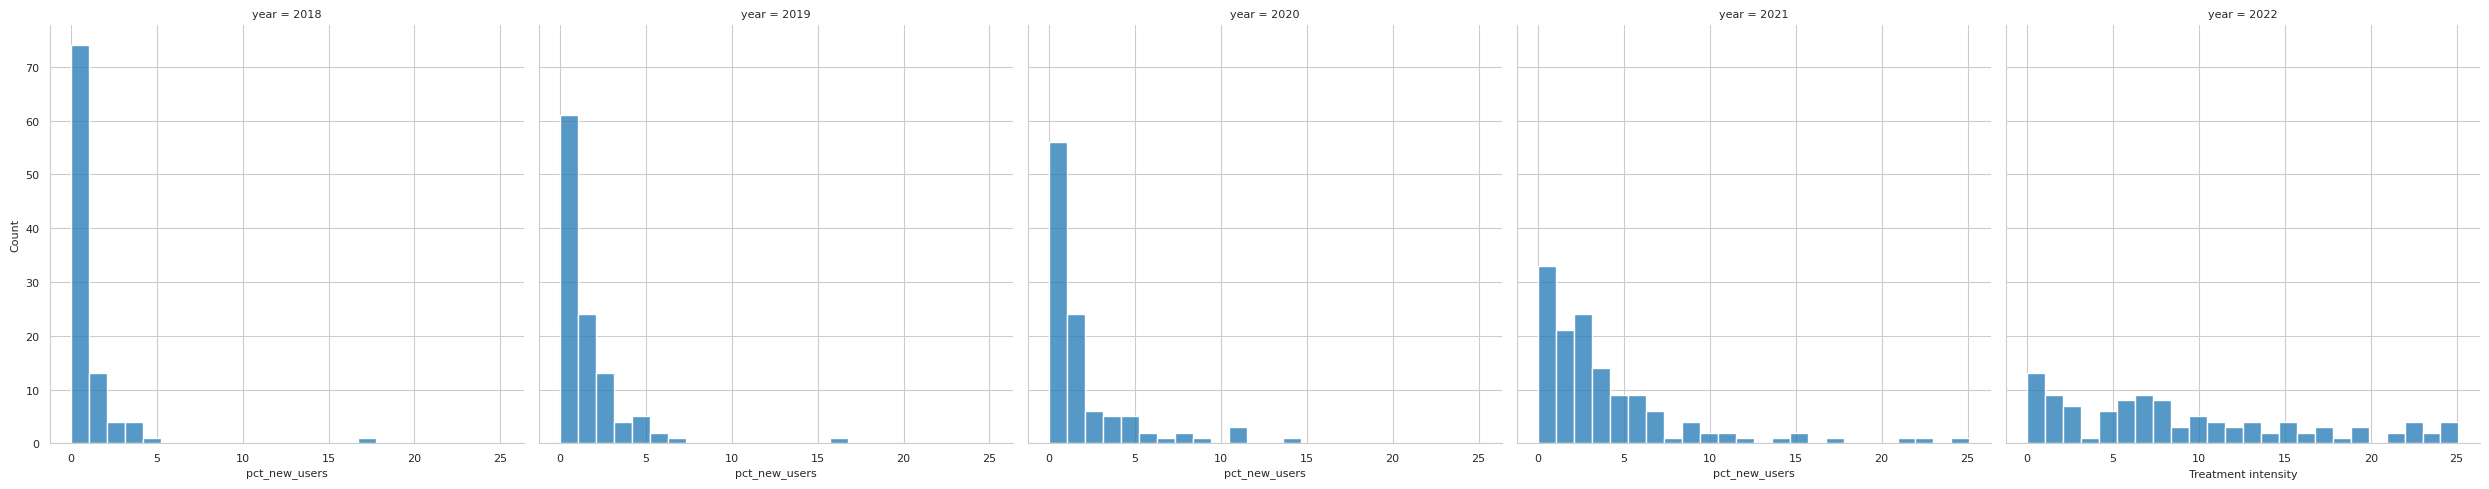

In [513]:
sns.displot(regions.query("year >= 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,25.1,25), col="year")
#plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

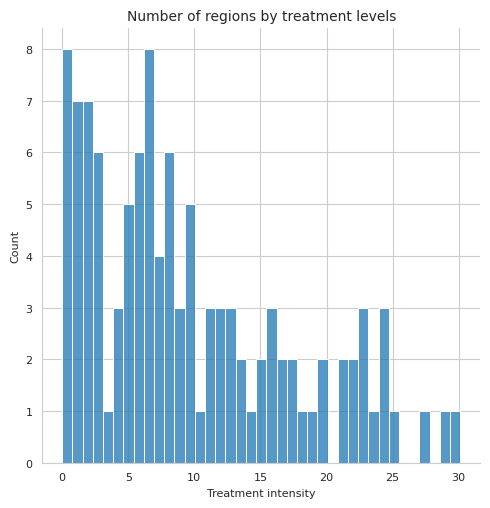

In [77]:
sns.displot(regions.query("year == 2022"),
             x="pct_new_users",
             bins=np.linspace(0.01,30.1,40))
plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

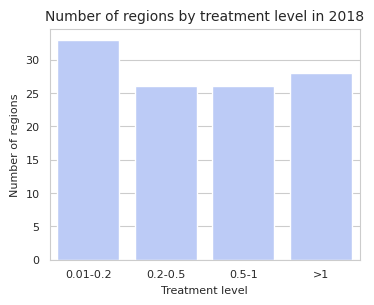

In [11]:
dict_hist = {
    "0.01-0.2": [0.01,0.2],
    "0.2-0.5": [0.2,0.5],
    "0.5-1": [0.5,1],
    ">1": [1,10],
}

regions_by_treat_level = binned_data(regions.query("year == 2018"), "pct_new_users", dict_hist)

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(regions_by_treat_level,
             x="labels", y="values",color=BINNED_COLOR)

plt.title("Number of regions by treatment level in 2018",fontsize=10)
plt.ylabel("Number of regions")
plt.xlabel(f"Treatment level")

plt.savefig("graphs/cities_by_treat_level.png", 
               bbox_inches='tight', )
plt.show()

### Scatter: City sizes by treatment levels

In [76]:
cities["diff_following_year"] = cities["hiv_het_pct_change_follow_year"] - cities["hiv_h_pct_change_follow_year"]
cities["diff_current_year"] = cities["hiv_het_pct_change"] - cities["hiv_h_pct_change"]

regions["diff_following_year"] = regions["hiv_het_pct_change_follow_year"] - regions["hiv_h_pct_change_follow_year"]
regions["diff_current_year"] = regions["hiv_het_pct_change"] - regions["hiv_h_pct_change"]

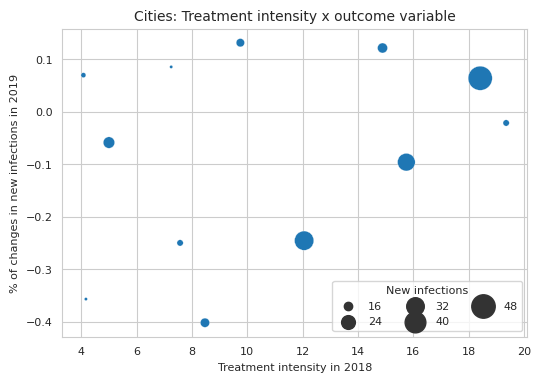

In [63]:
cases_scatter = cities.query(f"""year == 2022 & pct_following > 1 & pct_following < 20 & hiv_h > 5""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="diff_current_year",
                size="hiv_h",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Cities: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("graphs/cities_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

### Scatter: regions by treatment levels

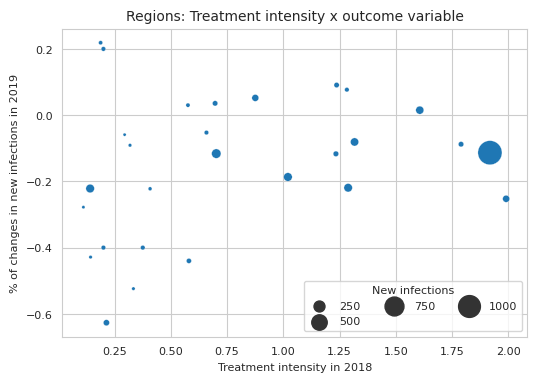

In [436]:
cases_scatter = regions.query(f"""year == 2018 & pct_following > 0.1 & pct_following < 3 & hiv_h_pct_change_follow_year < 0.25 & hiv_h > 15""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="hiv_h_pct_change_follow_year",
                size="hiv_h",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Regions: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("graphs/regions_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

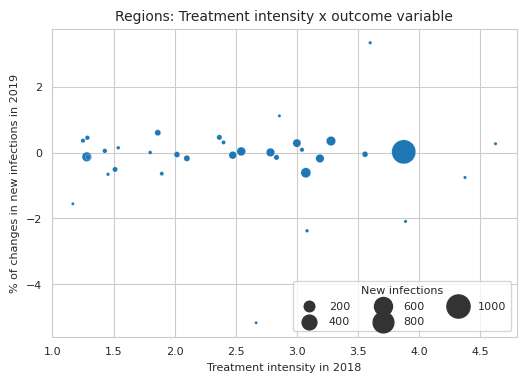

In [434]:
cases_scatter = regions.query(f"""year == 2019 & pct_following > 1 & pct_following < 5 & hiv_h > 5""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="diff_current_year",
                size="hiv_h",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Regions: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("graphs/regions_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

## PARALLEL TRENDS

##### define treatment

In [682]:
lower = 2
upper = 8
titles_same_city = [f"Treated cities ({lower} < pct_treat < {upper})",
                    f"Treated cities (pct_treat > {upper})"]

reference_year = 2021
# cities
cities["treated"] = 0

filter18_1 = cities[(cities["year"] == reference_year) & (cities["pct_new_users"].between(lower,upper))].index
cities.loc[filter18_1, "treated"] = 1

filter18_2 = cities[(cities["year"] == reference_year) & (cities["pct_new_users"] > upper)].index
cities.loc[filter18_2, "treated"] = 2

sizes_same_city=[len(cities.query(f"year == {reference_year} & treated == 1 ")),
                 len(cities.query(f"year == {reference_year} & treated == 2 "))]

# regions
titles_same_city = [f"Treated regions ({lower} < pct_treat < {upper})",
                    f"Treated regions (pct_treat > {upper})"]

regions["treated"] = 0
filter18_1 = regions[(regions["year"] == reference_year) & (regions["pct_new_users"].between(lower,upper))].index
regions.loc[filter18_1, "treated"] = 1

filter18_2 = regions[(regions["year"] == reference_year) & (regions["pct_new_users"] > upper)].index
regions.loc[filter18_2, "treated"] = 2

sizes_same_region=[len(regions.query(f"year == {reference_year} & treated == 1 ")),
                 len(regions.query(f"year == {reference_year} & treated == 2 "))]

##### city: homossexual x heterossexual

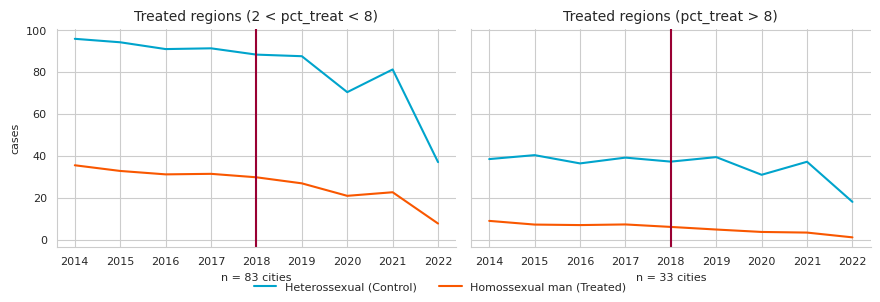

In [683]:
#graph = cities.query(f"hiv_h > 1 & year in {filter_years}")
graph = cities.query(f"treated.isin([1,2]) ")
graph = graph.query(f"year in {filter_years}")

graph["hiv_m_het"] = graph["hiv_m"] - graph["hiv_h"]
graph = melt_groups(graph.reset_index(),
                    ["hiv_m_het","hiv_h"])

graph.loc[graph["group"] == "hiv_m_het","group"]  = label_het
graph.loc[graph["group"] == "hiv_h","group"]  = label_gay

g = sns.relplot(graph.query("treated.isin([1,2])"),
                x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5,
                 palette=palette_hetgay,
                 hue_order=order_hetgay)
plt.xticks(filter_years, fontsize=8)

for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_city):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} cities")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)
plt.savefig("graphs/parallel_trends_treated_cities.png", 
               bbox_inches='tight')
plt.show()

##### region: homossexual x heterossexual

In [673]:
graph = regions.query(f"treated.isin([1,2]) ")
graph = graph.query(f"year in {filter_years}")

graph["hiv_m_het"] = graph["hiv_m"] - graph["hiv_h"]
graph = melt_groups(graph.reset_index(),
                    ["hiv_m_het","hiv_h"],
                   id_vars=["region_name","region_code","treated","year"])

graph.loc[graph["group"] == "hiv_m_het","group"]  = label_het
graph.loc[graph["group"] == "hiv_h","group"]  = label_gay

g = sns.relplot(graph.query("treated.isin([1,2])"),
                 x="year", y="cases", kind="line", estimator=np.mean,
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5,
                 palette=palette_hetgay,
                 hue_order=order_hetgay)

plt.xticks(filter_years, fontsize=8)
for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_region):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} regions")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)

plt.savefig("graphs/parallel_trends_treated_regions.png",
               bbox_inches='tight')
plt.show()

KeyError: 'hiv_m'

### Counterfactual 2: treated and non-treated cities

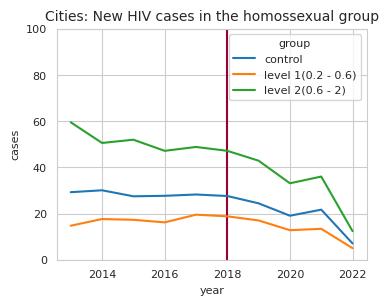

In [706]:
lower = 0.2
middle = 0.6
upper = 2

# cities
cities["treated"] = 0

filter18_1 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(lower,middle))].index
cities.loc[filter18_1, "treated"] = 1

filter18_2 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(middle,upper))].index
cities.loc[filter18_2, "treated"] = 2

filter_non_treated = cities[(cities["year"] == 2018) & (cities["hiv_h"] > 5) & (cities["treated"] == 0)].index
cities_non_treated = cities.loc[filter_non_treated]

filter_treated_1 = cities[(cities["year"] == 2018) & (cities["hiv_h"] > 5) & (cities["treated"] == 1)].index
cities_treated_1 = cities.loc[filter_treated_1]

filter_treated_2 = cities[(cities["year"] == 2018) & (cities["hiv_h"] > 5) & (cities["treated"] == 2)].index
cities_treated_2 = cities.loc[filter_treated_2]

cities_non_treated["cases"] = cities_non_treated["hiv_h"]
cities_non_treated["group"] = "control"
cities_non_treated = cities_non_treated.set_index('year', append=True)
#cities_non_treated["group"] = #"Homossexual group in control cities"

cities_treated_1["cases"] = cities_treated_1["hiv_h"]
cities_treated_1["group"] = "level 1(0.2 - 0.6)"
cities_treated_1 = cities_treated_1.set_index('year', append=True)
#cities_treated_1["group"] = #"Homossexual group in treated cities (0.2 < % treat < 0.7)"

cities_treated_2["cases"] = cities_treated_2["hiv_h"]
cities_treated_2["group"] = "level 2(0.6 - 2)"
cities_treated_2 = cities_treated_2.set_index('year', append=True)
#cities_treated_2["group"] = "Homossexual group in treated cities (treat > 0.7)"


cities_treated_control = pd.concat([cities_non_treated[["cases","group"]],
           cities_treated_1[["cases","group"]],
           cities_treated_2[["cases","group"]] ]
          ,axis=0).reset_index()

plt.title("")
plt.axvline(x=2018, color='#990033', linestyle='-')
g = sns.lineplot(cities_treated_control,
                x="year", y="cases", 
                errorbar=None, hue="group")
plt.title("Cities: New HIV cases in the homossexual group")
plt.ylim([0,100])
plt.show()

##### gays: treated and non-treated regions

(0.0, 120.0)

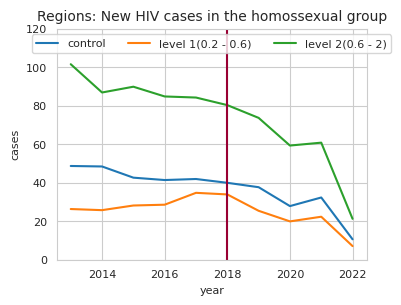

In [707]:
lower = 0.2
middle = 0.6
upper = 2

# cities
regions["treated"] = 0

filter18_1 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(lower,middle))].index
regions.loc[filter18_1, "treated"] = 1

filter18_2 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(middle,upper))].index
regions.loc[filter18_2, "treated"] = 2

filter_non_treated = regions[(regions["year"] == 2018) & (regions["hiv_h"].between(10,500)) & (regions["treated"] == 0)].index
cities_non_treated = regions.loc[filter_non_treated]

filter_treated_1 = regions[(regions["year"] == 2018) & (regions["hiv_h"].between(10,500)) & (regions["treated"] == 1)].index
cities_treated_1 = regions.loc[filter_treated_1]

filter_treated_2 = regions[(regions["year"] == 2018) & (regions["hiv_h"].between(10,500)) & (regions["treated"] == 2)].index
cities_treated_2 = regions.loc[filter_treated_2]

cities_non_treated["cases"] = cities_non_treated["hiv_h"]
cities_non_treated["group"] = "control"
cities_non_treated = cities_non_treated.set_index('year', append=True)
#cities_non_treated["group"] = #"Homossexual group in control cities"

cities_treated_1["cases"] = cities_treated_1["hiv_h"]
cities_treated_1["group"] = "level 1(0.2 - 0.6)"
cities_treated_1 = cities_treated_1.set_index('year', append=True)
#cities_treated_1["group"] = #"Homossexual group in treated cities (0.2 < % treat < 0.7)"

cities_treated_2["cases"] = cities_treated_2["hiv_h"]
cities_treated_2["group"] = "level 2(0.6 - 2)"
cities_treated_2 = cities_treated_2.set_index('year', append=True)
#cities_treated_2["group"] = "Homossexual group in treated cities (treat > 0.7)"

cities_treated_control = pd.concat([cities_non_treated[["cases","group"]],
           cities_treated_1[["cases","group"]],
           cities_treated_2[["cases","group"]] ]
          ,axis=0).reset_index()

g = sns.lineplot(cities_treated_control,
                x="year", y="cases", 
                errorbar=None, hue="group")
g.axvline(x=2018, color='#990033', linestyle='-')
plt.title("Regions: New HIV cases in the homossexual group")
sns.move_legend(g, "upper center", title="",fontsize=8, ncol=3)
plt.ylim([0,120])

#### COUNTERFACTUAL: HEPATITES

<AxesSubplot: xlabel='treatment_intensity', ylabel='Count'>

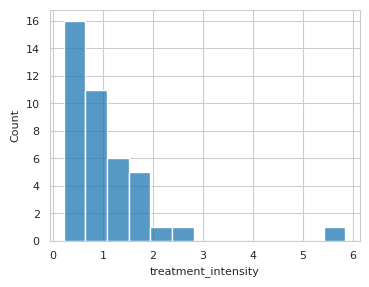

In [456]:
df = cities_reg[cities_reg["treatment_intensity"]!= np.inf].query("year == 2019")
sns.histplot(df.query("treatment_intensity > 0.2 & hiv_h > 10"), x="treatment_intensity")

In [474]:
lower = 0.2
upper = 0.7
titles_same_city = [f"Treated cities ({lower} < pct_treat < {upper})",
                    f"Treated cities (pct_treat > {upper})"]
# cities
df = cities_reg.copy()
df["treated"] = 0

filter19_1 = df[(df["year"] == 2019) & (df["pct_new_users"].between(lower,upper))].index
df.loc[filter18_1, "treated"] = 1

filter19_2 = cities[(df["year"] == 2019) & (df["pct_new_users"] > upper)].index
df.loc[filter18_2, "treated"] = 2

sizes_same_city=[len(df.query("year == 2019 & treated == 1 ")),
                 len(df.query("year == 2019 & treated == 2 "))]

graph = df.query(f"treated.isin([1,2]) ")
filter_years_hep = [2013,2014,2015,2016,2017,2018,2019,2020]
graph = graph.query(f"year in {filter_years_hep}")

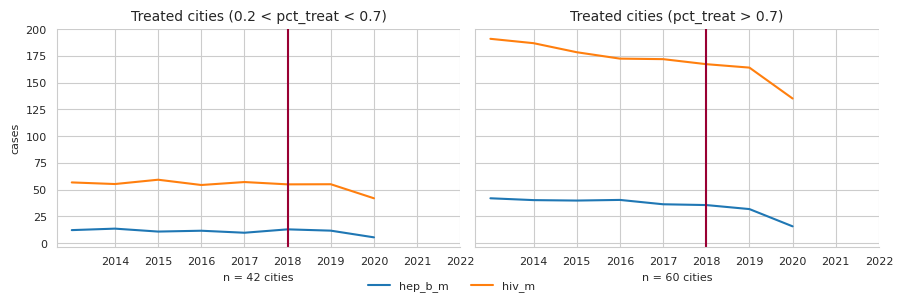

In [475]:

graph = melt_groups(graph.reset_index(),
                    ["hep_b_m","hiv_m"])

#graph.loc[graph["group"] == "hep_b_m","group"]  = "hep_b_m"
#graph.loc[graph["group"] == "hiv_h","group"]  = "hiv_h"

g = sns.relplot(graph.query("treated.isin([1,2])"),
                x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5)
plt.xticks(filter_years, fontsize=8)

for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_city):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} cities")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)
#plt.savefig("graphs/parallel_trends_treated_cities.png", 
#               bbox_inches='tight')
plt.show()

## create panel

In [252]:
#def wheighted_sum(values):
#    size = len(values)
#    if size == 1:
#        return values[0] / 2
#
#    summed_values = 0
#    for i,v in enumerate(values[0:(size-1)]):
#        print(i,v,size-i-1)
#        summed_values += v*(size-i)
#
#    return summed_values + (values[size-1] / 2)
#
#assert wheighted_sum([20]) == 10
#assert wheighted_sum([20, 50]) == 45 # 40 + 25
#assert wheighted_sum([20, 50, 200]) == 260 # 60 + 100 + 100

In [496]:
#cases.query("name.str.contains('Rio de J')")

In [497]:
#compute_treatment_intensity(cases.set_index("code").loc[330455])

In [567]:
cities_reg.query("name.str.contains('José do Rio Preto')")[["year","treatment_intensity"]]

,year,treatment_intensity
code,,
354980,2013,0.000000
354980,2014,0.000000
354980,2015,0.000000
354980,2016,0.000000
354980,2017,0.000000
354980,2018,0.000000
354980,2019,1.232143
354980,2020,4.035714
354980,2021,6.000000


In [566]:
cities_reg["cities_reg"] = (cities_reg["treatment_intensity"] > 2).astype(int)
cities_reg.groupby("year")["cities_reg"].mean()

year
2013    0.000000
2014    0.000000
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.009351
2020    0.022838
2021    0.032908
2022    0.045675
Name: cities_reg, dtype: float64

In [592]:
(cities_reg.reset_index()
    [["code","year","state_code","diff_treat_control","treatment_intensity",
         "hdi","gdpp","inappr_sanitation",
         "hiv_het","hiv_h"]]
    .to_stata("data/cities_with_outcome.dta"))
#regions_reg["state_code"] = regions_reg.index.astype(str).str.slice(0,2)
(regions_reg.reset_index()
    [["region_code","year","state_code","diff_treat_control","treatment_intensity",
         "hdi","gdpp","inappr_sanitation",
         "hiv_het","hiv_h"]]
    .to_stata("data/regions_with_outcome.dta"))

In [489]:
#cities_reg.loc[330455][["hiv_het",
#    "diff_to_baseline_het",
#    "pct_chg_to_baseline_het",
#    "hiv_h",
#    "diff_to_baseline_h",
#    "pct_chg_to_baseline_h",
#    "pct_chg_to_baseline_f",
#    "cummulative_prep",
#    "treatment_intensity",
#    "diff_treat_control",
#    "diff_treat_control_f"]]

In [636]:
cities_reg.query("year == 2022 & treatment_intensity > 2 & hiv_h > 5")

,year,name,hiv_total,hiv_m,hiv_f,hiv_h,hiv_bi,hiv_het,hep_a_total,hep_b_total,hep_b_m,hep_b_f,hep_a_dr,hep_b_dr,hep_a_dr_m,hep_b_dr_m,hep_a_dr_f,hep_b_dr_f,hep_c_total,hep_c_dr,hep_c_dr_m,hep_c_dr_f,region_type,city_code,started,following,loss_of_follow,new_users,pct_new_users,pct_following,population,hdi,gdpp,inappr_sanitation,state,region_name,region_code,state_code,hiv_total_pct_change,hep_b_total_pct_change,hep_b_m_pct_change,hep_b_f_pct_change,hiv_h_pct_change,hiv_het_pct_change,hiv_f_pct_change,hiv_het_pct_change_follow_year,hiv_h_pct_change_follow_year,diff_to_baseline_het,pct_chg_to_baseline_het,diff_to_baseline_f,pct_chg_to_baseline_f,diff_to_baseline_h,pct_chg_to_baseline_h,diff_treat_control,diff_treat_control_f,cummulative_prep,treatment_intensity
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
130260,2022,Manaus,543,419,124,50,14,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,130260.0,1305.0,921.0,384.0,280.0,5.600000,18.420000,2094391.0,0.737,790.27,6.45,13,Manaus,130001,13,-0.627316,0.0,0.0,0.0,-0.773756,-0.709677,-0.643678,NaN,NaN,-48.0,-0.400000,-125.0,-0.502008,-58.0,-0.537037,-0.137037,-0.035029,660.5,6.115741
140010,2022,Boa Vista,80,57,23,17,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,140010.0,234.0,144.0,90.0,36.0,2.117647,8.470588,326419.0,0.752,786.55,4.18,14,Boa Vista,140001,14,-0.518072,0.0,0.0,0.0,-0.32,-0.722222,-0.520833,NaN,NaN,-40.0,-0.800000,-33.0,-0.589286,-14.0,-0.451613,0.348387,0.137673,156.0,5.032258
150140,2022,Belém,332,252,80,36,6,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,150140.0,618.0,434.0,184.0,120.0,3.333333,12.055556,1446042.0,0.746,853.82,4.73,15,Belém,150001,15,-0.556742,0.0,0.0,0.0,-0.37931,-0.625,-0.624413,NaN,NaN,-71.0,-0.771739,-172.0,-0.682540,-93.0,-0.720930,0.050809,-0.038391,499.5,3.872093
150553,2022,Parauapebas,51,32,19,7,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,150553.0,31.0,21.0,10.0,6.0,0.857143,3.000000,196259.0,0.715,627.61,13.43,15,Parauapebas,150010,15,-0.337662,0.0,0.0,0.0,-0.5,-0.222222,-0.24,NaN,NaN,-17.0,-0.548387,-9.0,-0.321429,0.0,0.000000,0.548387,0.321429,24.0,3.428571
160030,2022,Macapá,76,53,23,9,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,160030.0,187.0,126.0,61.0,76.0,8.444444,14.000000,465495.0,0.733,717.88,16.25,16,Macapá,160001,16,-0.530864,0.0,0.0,NaN,-0.653846,-0.83871,-0.574074,NaN,NaN,-27.0,-0.843750,-30.0,-0.566038,-16.0,-0.640000,0.203750,-0.073962,96.5,3.860000
221100,2022,Teresina,105,86,19,12,4,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,221100.0,311.0,241.0,70.0,97.0,8.083333,20.083333,847430.0,0.751,757.57,2.23,22,Teresina,220001,22,-0.511628,0.0,0.0,0.0,-0.625,-0.380952,-0.525,NaN,NaN,-14.0,-0.518519,-27.0,-0.586957,-17.0,-0.586207,-0.067688,0.000750,255.5,8.810345
230440,2022,Fortaleza,215,169,46,19,6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,230440.0,1538.0,1238.0,300.0,441.0,23.210526,65.157895,2609716.0,0.754,846.36,1.11,23,Fortaleza,230001,23,-0.566532,0.0,0.0,0.0,-0.712121,-0.707317,-0.634921,NaN,NaN,-44.0,-0.785714,-120.0,-0.722892,-86.0,-0.819048,-0.033333,-0.096156,1137.0,10.828571
240800,2022,Mossoró,26,18,8,6,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,240800.0,112.0,81.0,31.0,35.0,5.833333,13.500000,291937.0,0.720,600.28,4.16,24,Mossoró,240009,24,-0.469388,NaN,NaN,NaN,-0.684211,-0.25,-0.111111,NaN,NaN,-14.0,-0.700000,-2.0,-0.200000,-21.0,-0.777778,-0.077778,-0.577778,85.0,3.148148
240810,2022,Natal,125,97,28,32,2,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,city,240810.0,642.0,504.0,138.0,182.0,5.687500,15.750000,877662.0,0.763,950.34,0.98,24,Natal,240001,24,-0.570447,0.0,0.0,0.0,-0.47541,-0.571429,-0.508772,NaN,NaN,-13.0,-0.464286,-60.0,-0.681818,-7.0,-0.179487,0.284799,0.502331,472.0,12.102564


In [638]:
#cities_reg.query("year == 2021 & hiv_het > 5 & treatment_intensity < 1 & state_code != 42")[["name","state_code","diff_treat_control"]]

In [616]:
cities_reg.query("name == 'São Paulo'")

,year,name,hiv_total,hiv_m,hiv_f,hiv_h,hiv_bi,hiv_het,hep_a_total,hep_b_total,hep_b_m,hep_b_f,hep_a_dr,hep_b_dr,hep_a_dr_m,hep_b_dr_m,hep_a_dr_f,hep_b_dr_f,hep_c_total,hep_c_dr,hep_c_dr_m,hep_c_dr_f,region_type,city_code,started,following,loss_of_follow,new_users,pct_new_users,pct_following,population,hdi,gdpp,inappr_sanitation,state,region_name,region_code,state_code,hiv_total_pct_change,hep_b_total_pct_change,hep_b_m_pct_change,hep_b_f_pct_change,hiv_h_pct_change,hiv_het_pct_change,hiv_f_pct_change,hiv_het_pct_change_follow_year,hiv_h_pct_change_follow_year,diff_to_baseline_het,pct_chg_to_baseline_het,diff_to_baseline_f,pct_chg_to_baseline_f,diff_to_baseline_h,pct_chg_to_baseline_h,diff_treat_control,diff_treat_control_f,cummulative_prep,treatment_intensity
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
355030,2013,São Paulo,2952,2210,742,870,132,524,97.0,1234.0,702.0,532.0,0.823471,10.475910,0.769707,12.565906,0.871972,8.590537,1306.0,11.087146,12.297404,9.995380,city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038168,0.111494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
355030,2014,São Paulo,3099,2352,745,967,149,544,109.0,1169.0,666.0,503.0,0.919034,9.856424,0.906591,11.839009,0.930260,8.067602,1307.0,11.019971,12.656718,9.543188,city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,0.049797,-0.052674,-0.051282,-0.054511,0.111494,0.038168,0.004043,-0.147059,-0.067218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
355030,2015,São Paulo,2831,2150,680,902,148,464,104.0,1286.0,762.0,524.0,0.870800,10.767780,1.006089,13.449821,0.748702,8.347227,3729.0,31.223214,35.442572,27.415224,city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,-0.08648,0.100086,0.144144,0.04175,-0.067218,-0.147059,-0.087248,-0.036638,-0.034368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
355030,2016,São Paulo,2740,2119,621,871,156,447,43.0,1180.0,696.0,484.0,0.357650,9.814591,0.333097,12.201859,0.379815,7.659601,3868.0,32.171896,35.150469,29.483134,city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,-0.032144,-0.082426,-0.086614,-0.076336,-0.034368,-0.036638,-0.086765,0.073826,0.022962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
355030,2017,São Paulo,2735,2147,585,891,135,480,743.0,1194.0,654.0,540.0,6.140553,9.867861,11.129907,11.391172,1.635580,8.492437,4104.0,33.917672,37.935738,30.273964,city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,-0.001825,0.011864,-0.060345,0.115702,0.022962,0.073826,-0.057971,-0.10625,-0.022447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
355030,2018,São Paulo,2711,2148,563,871,134,429,475.0,1157.0,636.0,521.0,3.900840,9.501624,6.264454,11.006057,1.766113,8.142877,4092.0,33.604706,36.773384,30.727248,city,355030.0,2723.0,2193.0,530.0,2193.0,2.517796,2.517796,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,-0.008775,-0.030988,-0.027523,-0.035185,-0.022447,-0.10625,-0.037607,-0.048951,-0.166475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
355030,2019,São Paulo,2498,1971,527,726,113,408,135.0,895.0,486.0,409.0,1.101859,7.304916,1.857200,8.357401,0.419462,6.354071,3355.0,27.383233,30.712589,24.359862,city,355030.0,5269.0,3783.0,1486.0,1590.0,2.190083,5.210744,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,-0.078569,-0.226448,-0.235849,-0.214971,-0.166475,-0.048951,-0.063943,-0.223039,-0.090909,-21.0,-0.048951,-36.0,-0.063943,-145.0,-0.166475,-0.117524,-0.102532,795.0,0.912744
355030,2020,São Paulo,2231,1759,472,660,94,317,43.0,386.0,225.0,161.0,0.348878,3.131787,0.376015,3.845604,0.324355,2.486718,1186.0,9.622537,11.929919,7.537383,city,355030.0,8644.0,6437.0,2207.0,2654.0,4.021212,9.753030,12038175.0,0.805,1516.21,0.47,35,São Paulo,350001,35,-0.106886,-0.568715,-0.537037,-0.606357,-0.090909,-0.223039,-0.104364,-0.113565,0.057576,-112.0,-0.261072,-91.0,-0.161634,-211.0,-0.242250,0.018822,-0.080616,3712.0,4

(33, 33)


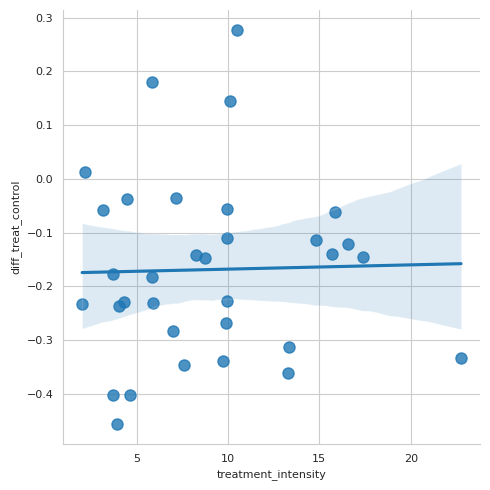

In [745]:
index_regions = regions_reg.query("year == 2018 & hiv_h >= 30").index
plot_df = (regions_reg.loc[index_regions]
                .query("year.between(2022,2022) & treatment_intensity.between(2,30)"))
print(plot_df.shape)
scat = (plot_df
        [["treatment_intensity","diff_treat_control"]])
sns.lmplot(scat, x="treatment_intensity",y="diff_treat_control")#treatment_intensity.between(0,1) & 
plt.show()

In [632]:
regions_reg.loc[110005][["treatment_intensity","diff_treat_control","hiv_het","hiv_h"]]#.query("diff_treat_control > 2")

,treatment_intensity,diff_treat_control,hiv_het,hiv_h
region_code,,,,
110005,0.0,NaN,8,2
110005,0.0,NaN,8,3
110005,0.0,NaN,6,4
110005,0.0,NaN,2,1
110005,0.0,NaN,4,1
110005,0.0,NaN,3,1
110005,0.0,2.000000,3,3
110005,0.5,3.333333,2,4
110005,2.5,3.333333,2,4


# Estimation

### Model 1 (pre-covid): binary treatment version: two-way fixed effects

$\Delta_{i_{t+1}} = \beta treat * post + X_i + \sigma_i + \tau_t + \epsilon_i $

$\Delta_{i_{t+1}}$: variation in the % of cases for city i in year t+1

$ treat $: indicator if in a city i, treatment was above a certain threshold

$X_i$: controls: (city characteristics, health service indicators)

$\sigma_i$: city/region FE

$\tau_t$: year FE

### Model 2 (pre and postcovid): continuous treatment version

# Results: nothing significant



_

# Issues for identification:
#### selection into treatment: bigger cities offer more treatment
#### big confounder: covid



_

# Issues for estimation:
#### small sample
#### continous treatment
#### dynamic effects
#### for binary treatment: establishing the threshold
#### how to properly weight city sizes



_

# Key takeaway:
##### The ammount of treatment was not enough to have an impact in the reduction of cases in the treatment group



_

# Contributions:
#### Dataset for future research
#### This policy was the main innovation in the prevention of HIV in the past decade. This paper is first time it is evaluated as an observational study with
#### If time allows: python package for continuous treatment effect estimation (Callaway/Sant'anna/Goodman-Bacon, Chaisemartin and d'haultfoeuille



_

# Sidenote
#### All results are on github and easily reproducible



_

# TODO:
* WRITE
* Add controls
* Account for old HIV cases
* Think of weighting/matching
* Try the hepatites cases as a counterfactual
* Try continous treatment estimation

In [760]:
y_1 = np.random.normal(0, 1, 1000)
e = np.random.normal(0, 0.1, 1000)
y_2 = y_1 + 1 + e

d_1 = np.tile(0,1000)
d_2 = np.tile(1,1000)

y = np.hstack( [y_1,y_2] )
d = np.hstack( [d_1,d_2] )

#y = 2*x + e
#
#{"x":x,
# "y":y}

In [761]:
d

array([0, 0, 0, ..., 1, 1, 1])